In [1]:
# Import libraries
import os
root = os.path.dirname(os.getcwd())
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load the CIFAR-10 dataset and take a 5000 sample subset


# Train set
# Load Full CIFAR-10 Dataset (Without Transform)
full_trainset = torchvision.datasets.CIFAR10(root=root + '/data', train=True, download=True, transform=None)

# Shuffle dataset before splitting
indices = torch.randperm(len(full_trainset))  
full_trainset = torch.utils.data.Subset(full_trainset, indices)  

# Take a 5000-sample subset
trainset = torch.utils.data.Subset(full_trainset, range(5000))  # No transform yet
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)  # For normal training


In [3]:
class CustomDataset(torch.utils.data.Dataset):
    """ Wrapper dataset that applies transforms to a given subset """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

In [4]:
# Data Augmentation

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.RandomGrayscale(p=0.15),
                                transforms.ToTensor(), # Convert image to tensor
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize data to [-1, 1]


val_transform = transforms.Compose([transforms.ToTensor(), # Convert image to tensor,
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize data to [-1, 1]

In [6]:
k_folds=5
batch_size=32
# Create folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# Loop through the folds
for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
    print(f"\n----- Fold {fold+1} / {k_folds} -----")
    # Create dataset subsets from `trainset`, applying correct transform
    train_subsampler = Subset(trainset, train_idx)
    val_subsampler = Subset(trainset, val_idx)
    # Wrap them with Dataset objects to apply transforms
    train_dataset = CustomDataset(train_subsampler, train_transform)
    val_dataset = CustomDataset(val_subsampler, val_transform)
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    if fold==0:
        break
        
        


----- Fold 1 / 5 -----


In [9]:
import numpy as np

# Assuming train_loader is for the first fold's training set
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())

# Convert to numpy array and count unique values
all_labels = np.array(all_labels)
unique, counts = np.unique(all_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Training class distribution (first fold):", class_distribution)

Training class distribution (first fold): {0: 400, 1: 398, 2: 367, 3: 417, 4: 407, 5: 409, 6: 426, 7: 390, 8: 395, 9: 391}


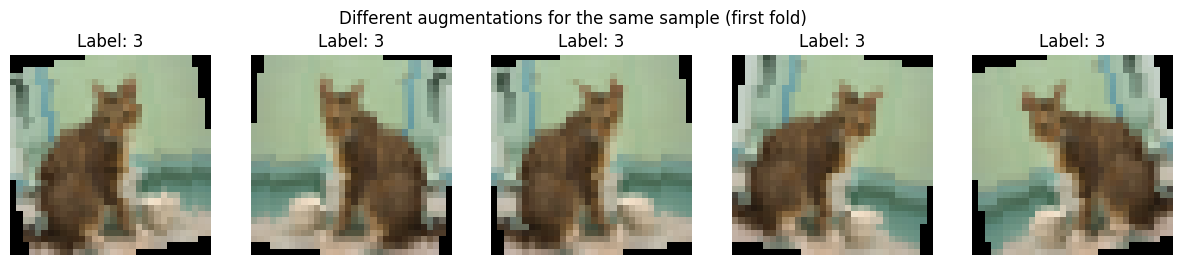

In [10]:
import matplotlib.pyplot as plt

# Pick a sample index from the first fold training dataset
sample_idx = 0

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Each call to train_dataset[sample_idx] should apply augmentation anew.
    img, label = train_dataset[sample_idx]
    # Undo the normalization: (x * std) + mean, here std=0.5 and mean=0.5
    img = img * 0.5 + 0.5
    # Convert image tensor from (C, H, W) to (H, W, C) for plotting
    img_np = img.permute(1, 2, 0).numpy()
    axes[i].imshow(np.clip(img_np, 0, 1))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.suptitle("Different augmentations for the same sample (first fold)")
plt.show()